In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tikzplotlib
from scipy.ndimage.filters import gaussian_filter1d

/tmp/ipykernel_4085217/224117149.py:6: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [27]:
def collect_data_csv(exp_path, seeds, timesteps=245):
    results = np.zeros((seeds, timesteps, 3))
    for seed in range(seeds):
        data_pth  = os.path.join("%s_s_%d" % (exp_path, seed) ,'eval.csv') 
        data = pd.read_csv(data_pth, sep=',', header=0)
        num_samples = data['num_timesteps'].to_numpy()
        return_arr = data['return'].to_numpy()
        bias = data['bias'].to_numpy()
        results[seed, :, 0] = num_samples
        results[seed, :, 1] = return_arr
        results[seed, :, 2] = bias

    return results

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)


def bootstrapping(data, num_per_group, num_of_group):
    new_data = np.array([np.mean(np.random.choice(data, num_per_group, replace=True)) for _ in range(num_of_group)])
    return new_data


def generate_confidence_interval(ys, number_per_g = 30, number_of_g = 1000, low_percentile = 1, high_percentile = 99):
    means = []
    mins =[]
    maxs = []
    for i,y in enumerate(ys.T):
        y = bootstrapping(y, number_per_g, number_of_g)
        means.append(np.mean(y))
        mins.append(np.percentile(y, low_percentile))
        maxs.append(np.percentile(y, high_percentile))
    return np.array(means), np.array(mins), np.array(maxs)


def plot_ci(plt, x, y, num_runs, num_dots, linestyle='-', linewidth=3, transparency=0.2, c='red', sigma=2.0, label=None):
    assert (x.ndim==1) and (y.ndim==2)
    assert(x.size==num_dots) and (y.shape==(num_runs,num_dots))
    y_mean, y_min, y_max = generate_confidence_interval(y)
    y_mean = gaussian_filter1d(y_mean, sigma=sigma)
    y_max = gaussian_filter1d(y_max, sigma=sigma)
    y_min = gaussian_filter1d(y_min, sigma=sigma)
    plt.plot(x, y_mean, linestyle=linestyle, linewidth=linewidth, color=c, label=label)
    plt.fill_between(x, y_min, y_max, alpha=transparency, color=c)
    return


def load_and_plot(exp_dict, model_color_dict, title, reward_low=9500, reward_high=12000, file_name='output', timesteps=245):
    fig = plt.figure(figsize=(14, 6))
    fig.suptitle(title, fontsize=18)

    plt1 = fig.add_subplot(1, 2, 1)
    plt1.set_title("Rewards", fontsize=16)
    plt1.set_ylabel('Rewards', fontsize=16)
    plt1.set_xlabel('Training timestep', fontsize=16)

    plt2 = fig.add_subplot(1, 2, 2)
    plt2.set_title("Bias", fontsize=16)
    plt2.set_ylabel('Bias', fontsize=16)
    plt2.set_xlabel('Training timestep', fontsize=16)

    for model in exp_dict.keys():
        data = collect_data_csv(exp_dict[model][0], exp_dict[model][1], timesteps)
        indexes = data[:, :, 0]
        if model=="CPO":
            print(model)
            indexes = indexes*7
        rewards = data[:, :, 1]
        bias = data[:, :, 2]
        # rewards = gaussian_filter1d(rewards, sigma=1)
        # bias = gaussian_filter1d(bias, sigma=1)
        # plt1.plot(indexes[0], rewards.mean(axis=0), linewidth=2, c=model_color_dict[model], label=model)
        # plt1.fill_between(indexes[0], rewards.min(axis=0), rewards.max(axis=0), color=model_color_dict[model], alpha=0.2)
        # plt2.plot(indexes[0], bias.mean(axis=0), linewidth=2, c=model_color_dict[model], label=model)
        # plt2.fill_between(indexes[0], bias.min(axis=0), bias.max(axis=0), color=model_color_dict[model], alpha=0.2)
        num_runs = indexes.shape[0]
        num_dots = indexes.shape[1]
        plot_ci(plt1, indexes[0], rewards, num_runs=num_runs, num_dots=num_dots, linewidth=2, c=model_color_dict[model], label=model)
        plot_ci(plt2, indexes[0], np.abs(bias), num_runs=num_runs, num_dots=num_dots, linewidth=2, c=model_color_dict[model], label=model)

    # plt1.set_ylim((reward_low, reward_high))
    # plt1.set_xlim((0, 5e6))
    plt1.grid()
    #plt1.legend()

    # plt2.set_ylim((0, 0.3))
    # plt2.set_xlim((0, 5e6))
    plt2.grid()
    plt2.legend()

    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(os.path.join("figures", file_name+'.tex'))


def load_and_plot_rewards(exp_dict, model_color_dict, reward_low=9500, reward_high=12000, file_name='output'):
    fig = plt.figure(figsize=(6.5, 6))

    plt1 = fig.add_subplot(1, 1, 1)
    plt1.set_title("Rewards", fontsize=18)
    plt1.set_ylabel('Rewards', fontsize=18)
    plt1.set_xlabel('Training timestep', fontsize=18)

    for model in exp_dict.keys():
        data = collect_data_csv(exp_dict[model][0], exp_dict[model][1])
        indexes = data[:, :, 0]
        rewards = data[:, :, 1]
        num_runs = indexes.shape[0]
        num_dots = indexes.shape[1]
        plot_ci(plt1, indexes[0], rewards, num_runs=num_runs, num_dots=num_dots, linewidth=2, c=model_color_dict[model], label=model)

    # plt1.set_ylim((reward_low, reward_high))
    # plt1.set_xlim((0, 5e6))
    plt1.grid()
    plt1.legend(loc='lower right')

    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(os.path.join("figures", file_name+'_rewards.tex'))


def load_and_plot_bias(exp_dict, model_color_dict, file_name='output'):
    fig = plt.figure(figsize=(6.5, 6))

    plt2 = fig.add_subplot(1, 1, 1)
    plt2.set_title("Bias", fontsize=18)
    plt2.set_ylabel('Bias', fontsize=18)
    plt2.set_xlabel('Training timestep', fontsize=18)

    for model in exp_dict.keys():
        data = collect_data_csv(exp_dict[model][0], exp_dict[model][1])
        indexes = data[:, :, 0]
        bias = data[:, :, 2]
        num_runs = indexes.shape[0]
        num_dots = indexes.shape[1]
        plot_ci(plt2, indexes[0], np.abs(bias), num_runs=num_runs, num_dots=num_dots, linewidth=2, c=model_color_dict[model], label=model)

    # plt2.set_ylim((0, 0.3))
    # plt2.set_xlim((0, 5e6))
    plt2.grid()
    plt2.legend(loc='upper right')

    # tikzplotlib_fix_ncols(fig)
    # tikzplotlib.save(os.path.join("figures", file_name+'_bias.tex'))

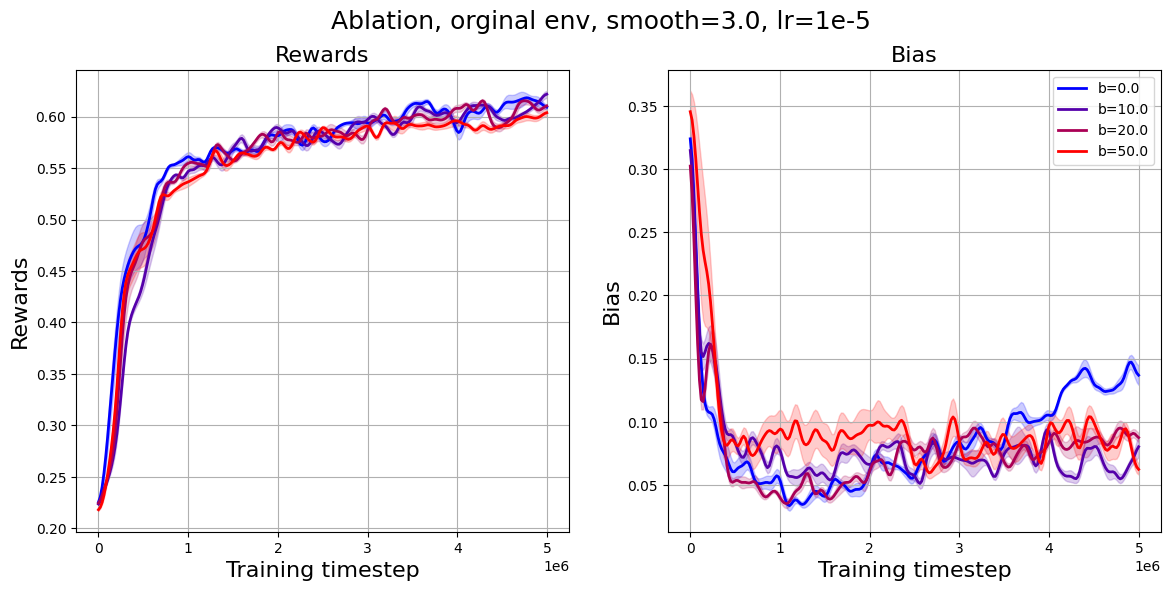

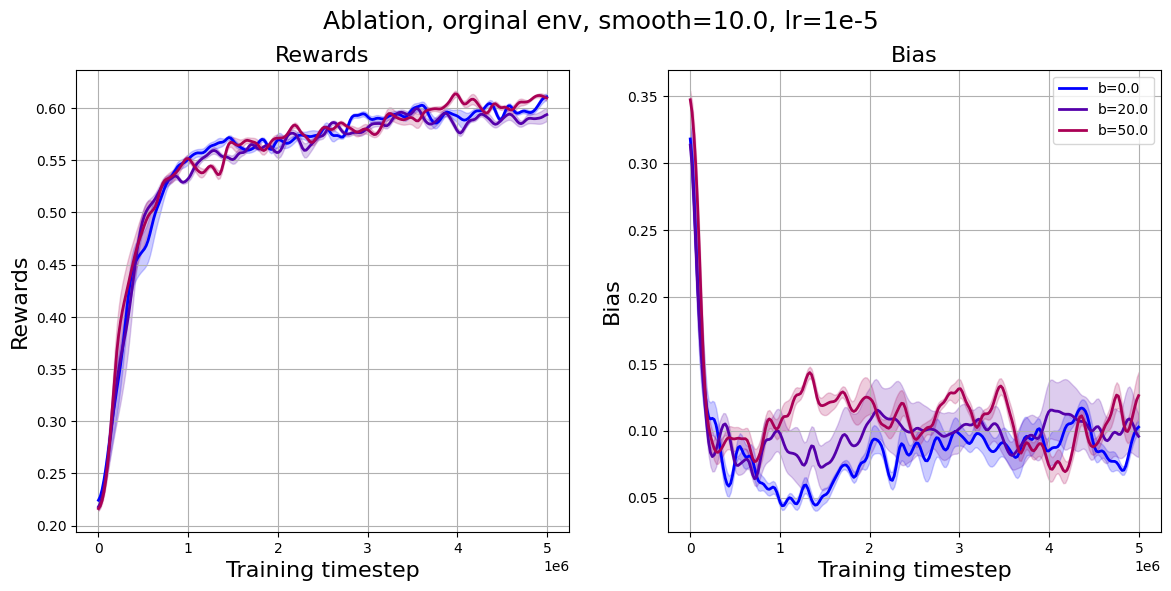

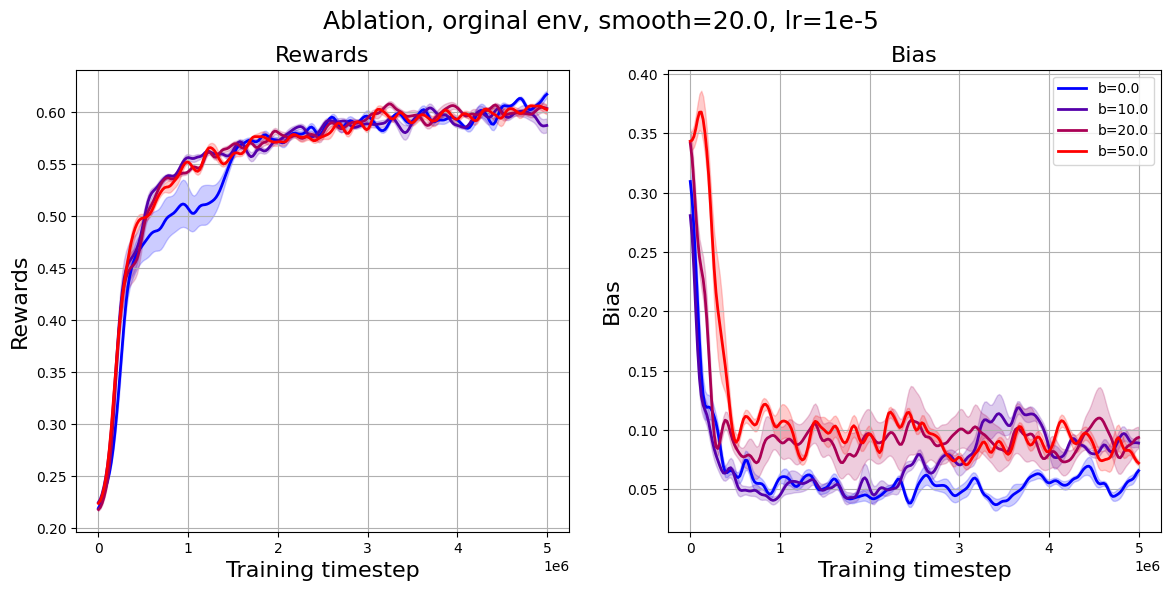

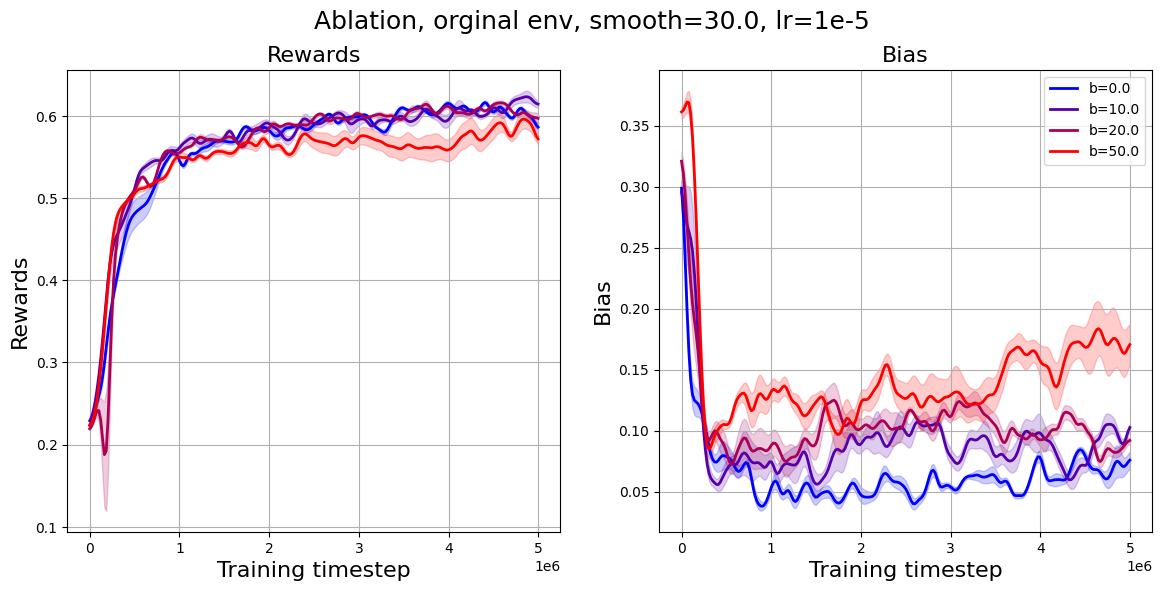

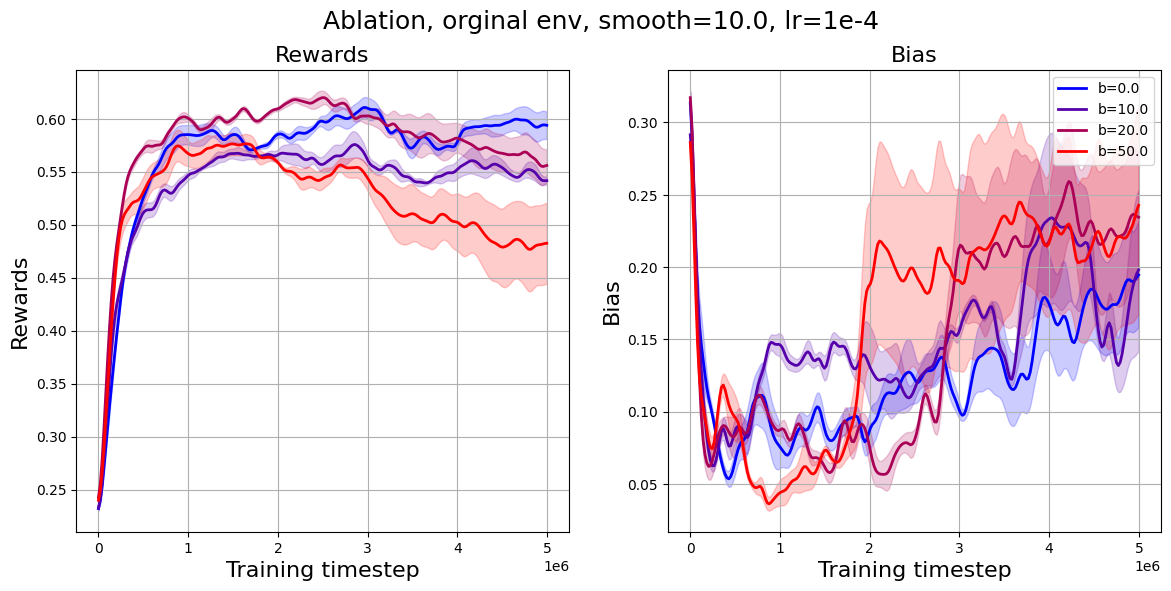

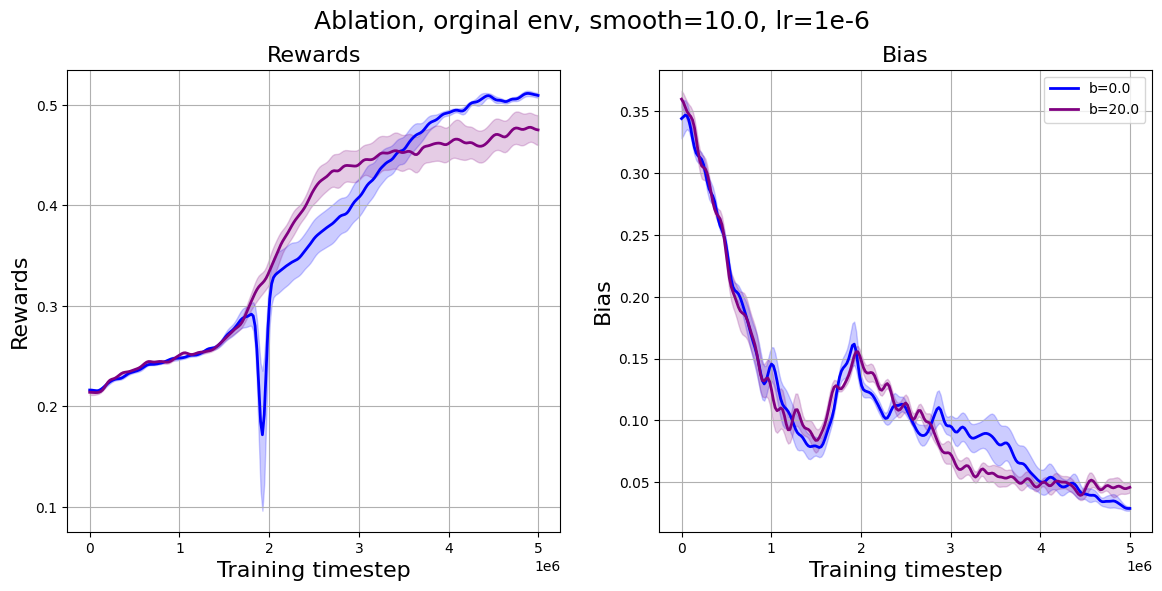

In [28]:
ablation_ori_smooth3_dict = {
    "b=0.0":("experiments/original/ours/Smooth_3.0/b_0.0", 2),
    "b=10.0":("experiments/original/ours/Smooth_3.0/b_10.0", 2),
    "b=20.0":("experiments/original/ours/Smooth_3.0/b_20.0", 2),
    "b=50.0":("experiments/original/ours/Smooth_3.0/b_50.0", 2)
}

ablation_ori_smooth10_dict = {
    "b=0.0":("experiments/original/ours/Smooth_10.0/b_0.0", 2),
    "b=20.0":("experiments/original/ours/Smooth_10.0/b_20.0", 2),
    "b=50.0":("experiments/original/ours/Smooth_10.0/b_50.0", 2),
    #"b=100.0":("experiments/original/ours/Smooth_10.0/b_100.0", 2)
}

ablation_ori_smooth20_dict = {
    "b=0.0":("experiments/original/ours/Smooth_20.0/b_0.0_lr1e-5", 2),
    "b=10.0":("experiments/original/ours/Smooth_20.0/b_10.0_lr1e-5", 2),
    "b=20.0":("experiments/original/ours/Smooth_20.0/b_20.0_lr1e-5", 2),
    "b=50.0":("experiments/original/ours/Smooth_20.0/b_50.0_lr1e-5", 2)
}

ablation_ori_smooth30_dict = {
    "b=0.0":("experiments/original/ours/Smooth_30.0/b_0.0_lr1e-5", 2),
    "b=10.0":("experiments/original/ours/Smooth_30.0/b_10.0_lr1e-5", 2),
    "b=20.0":("experiments/original/ours/Smooth_30.0/b_20.0_lr1e-5", 2),
    "b=50.0":("experiments/original/ours/Smooth_30.0/b_50.0_lr1e-5", 2)
}

ablation_ori_smooth10_4_dict = {
    "b=0.0":("experiments/original/ours/Smooth_10.0/b_0.0_lr1e-4", 2),
    "b=10.0":("experiments/original/ours/Smooth_10.0/b_10.0_lr1e-4", 2),
    "b=20.0":("experiments/original/ours/Smooth_10.0/b_20.0_lr1e-4", 2),
    "b=50.0":("experiments/original/ours/Smooth_10.0/b_50.0_lr1e-4", 2)
}

ablation_ori_smooth10_6_dict = {
    "b=0.0":("experiments/original/ours/Smooth_10.0/b_0.0_lr1e-6", 2),
    "b=20.0":("experiments/original/ours/Smooth_10.0/b_20.0_lr1e-6", 2),
    #"b=50.0":("experiments/original/ours/Smooth_10.0/b_50.0_lr1e-6", 2),
}

def alpha_color(alpha, color0=(1,0,0), color1=(0,0,1)):
    np_color0 = np.asarray(color0)
    np_color1 = np.asarray(color1)
    return tuple(alpha*np_color0+(1-alpha)*np_color1)

ablation_color_dict1 = {
    "b=0.0":alpha_color(0.0),
    "b=10.0":alpha_color(1.0/3),
    "b=20.0":alpha_color(2.0/3),
    "b=50.0":alpha_color(1.0)
}

ablation_color_dict2 = {
    "b=0.0":alpha_color(0.0),
    "b=20.0":alpha_color(1.0/3),
    "b=50.0":alpha_color(2.0/3),
    "b=100.0":alpha_color(1.0)
}

ablation_color_dict3 = {
    "b=0.0":alpha_color(0.0),
    "b=20.0":alpha_color(1.0/2),
    "b=50.0":alpha_color(1.0)
}

load_and_plot(ablation_ori_smooth3_dict, ablation_color_dict1, "Ablation, orginal env, smooth=3.0, lr=1e-5", "fig_lending")
load_and_plot(ablation_ori_smooth10_dict, ablation_color_dict2, "Ablation, orginal env, smooth=10.0, lr=1e-5", "fig_lending")
load_and_plot(ablation_ori_smooth20_dict, ablation_color_dict1, "Ablation, orginal env, smooth=20.0, lr=1e-5", "fig_lending")
load_and_plot(ablation_ori_smooth30_dict, ablation_color_dict1, "Ablation, orginal env, smooth=30.0, lr=1e-5", "fig_lending")
load_and_plot(ablation_ori_smooth10_4_dict, ablation_color_dict1, "Ablation, orginal env, smooth=10.0, lr=1e-4", "fig_lending")
load_and_plot(ablation_ori_smooth10_6_dict, ablation_color_dict3, "Ablation, orginal env, smooth=10.0, lr=1e-6", "fig_lending")

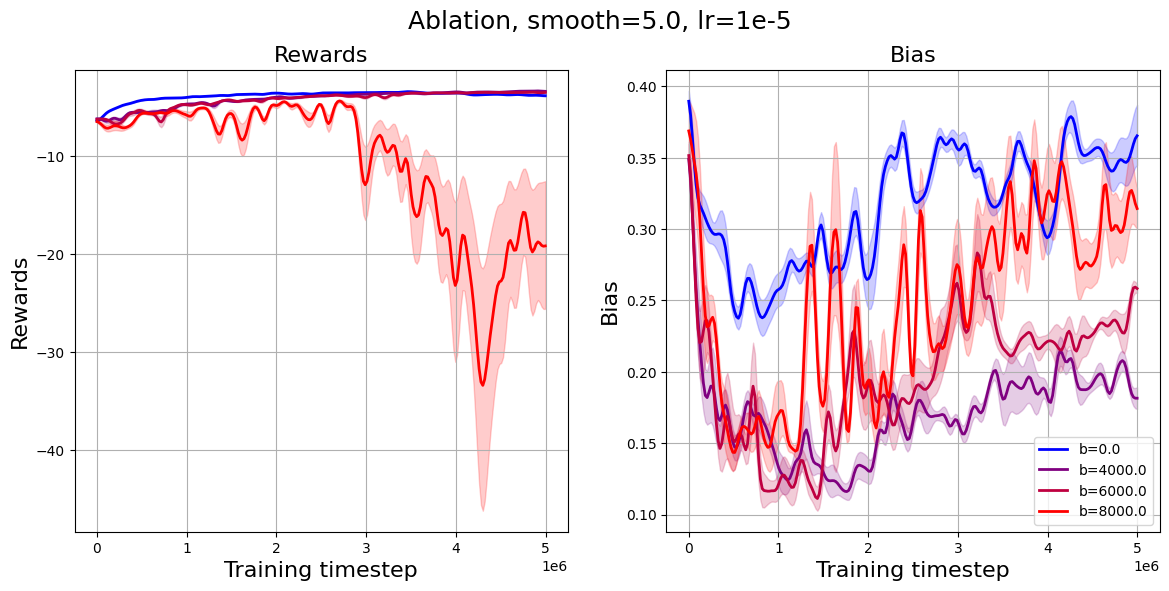

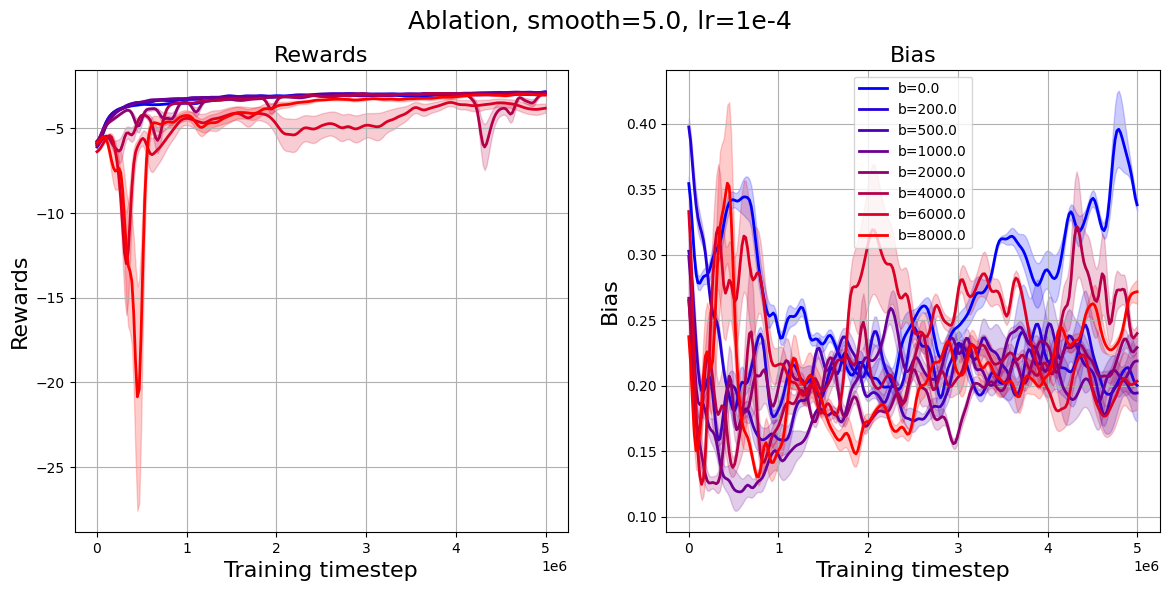

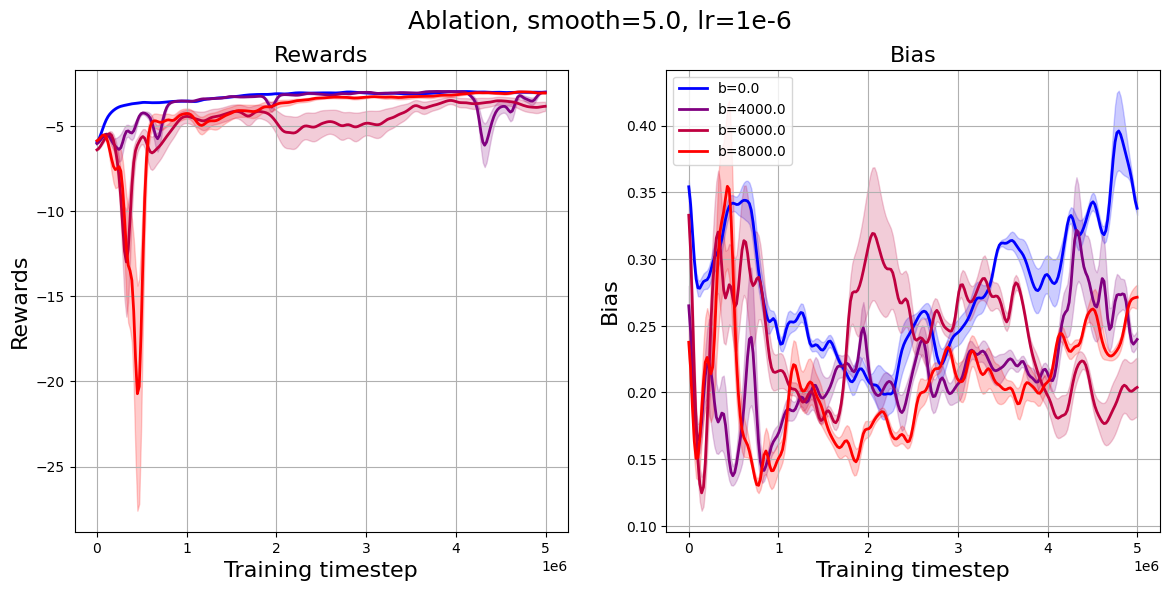

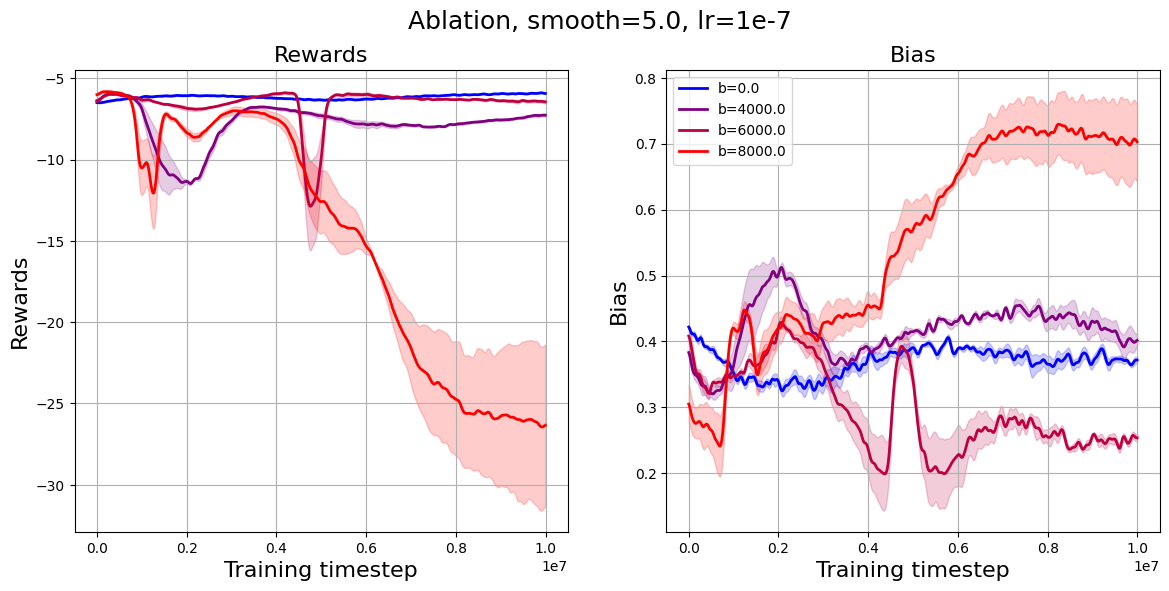

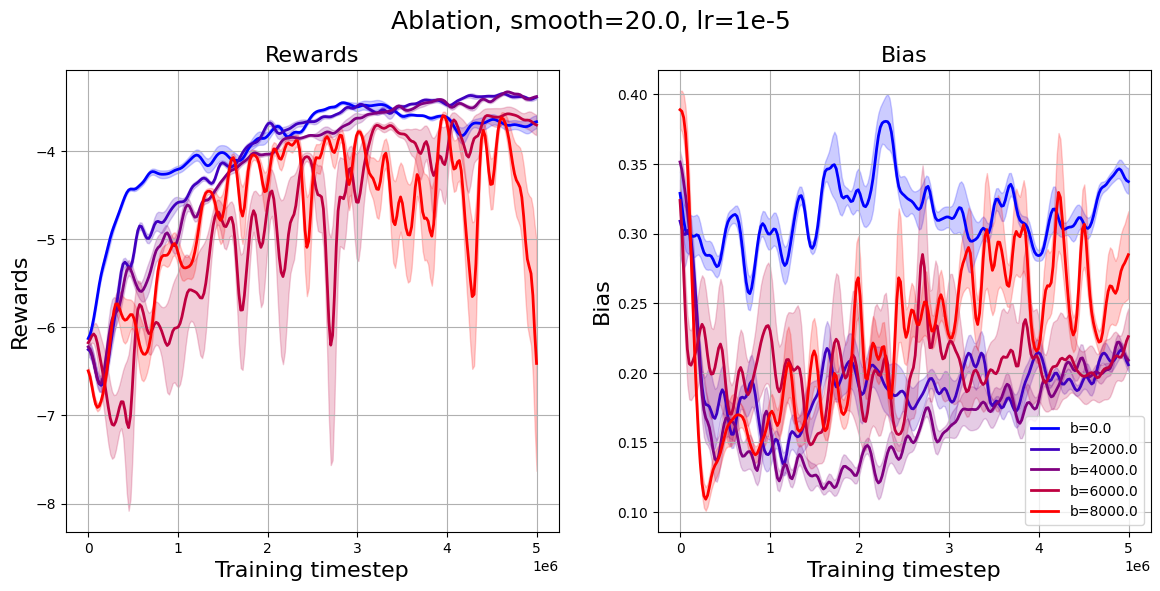

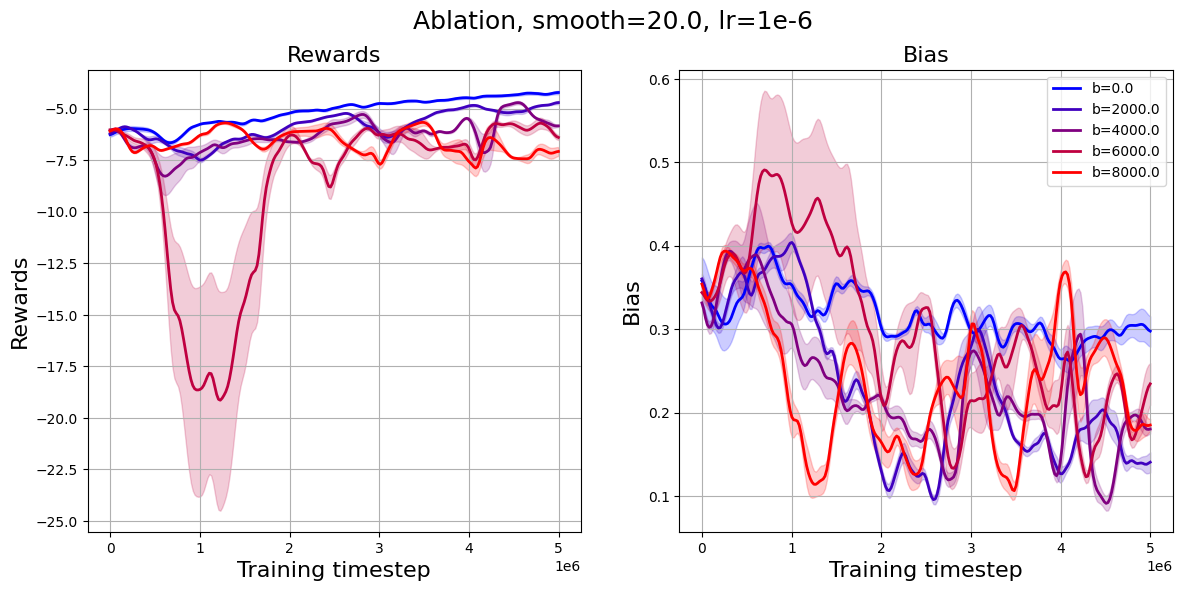

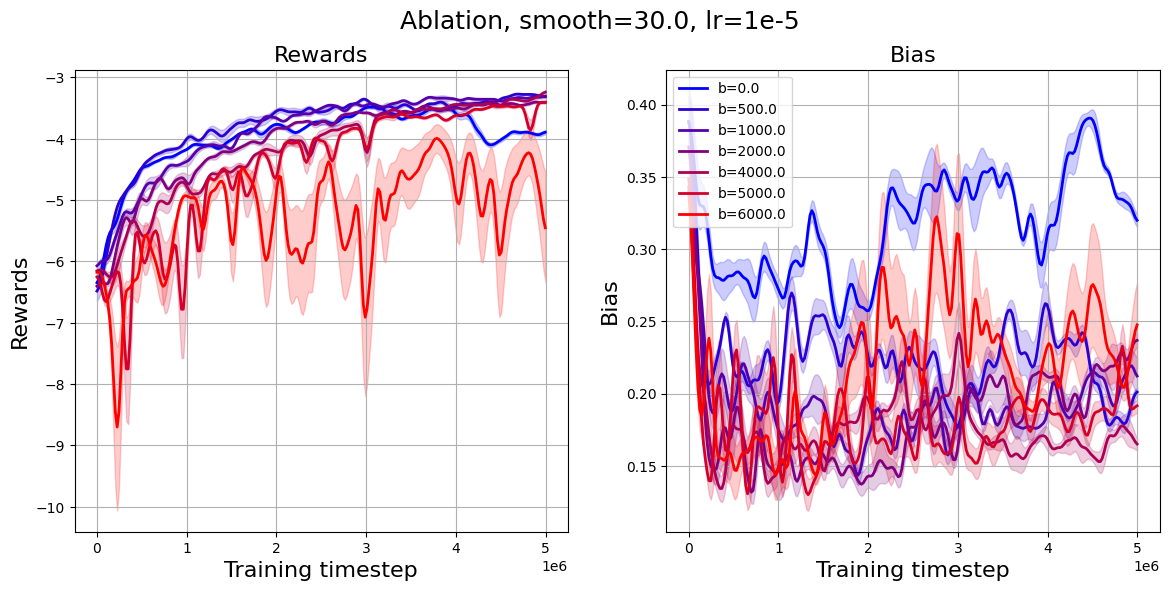

In [29]:
def alpha_color(alpha, color0=(1,0,0), color1=(0,0,1)):
    np_color0 = np.asarray(color0)
    np_color1 = np.asarray(color1)
    return tuple(alpha*np_color0+(1-alpha)*np_color1)

ablation_mod_smooth5_dict = {
    "b=0.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_0.0", 2),
    "b=4000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_4000.0", 2),
    "b=6000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_6000.0", 2),
    "b=8000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_8000.0", 2)
}

ablation_mod_smooth5_4_dict = {
    "b=0.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_0.0_lr1e-4", 2),
    "b=200.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_200.0_lr1e-4", 2),
    "b=500.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_500.0_lr1e-4", 2),
    "b=1000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_1000.0_lr1e-4", 2),
    "b=2000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_2000.0_lr1e-4", 2),
    "b=4000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_4000.0_lr1e-4", 2),
    "b=6000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_6000.0_lr1e-4", 2),
    "b=8000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_8000.0_lr1e-4", 2)
}

ablation_mod_smooth5_6_dict = {
    "b=0.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_0.0_lr1e-4", 2),
    "b=4000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_4000.0_lr1e-4", 2),
    "b=6000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_6000.0_lr1e-4", 2),
    "b=8000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_8000.0_lr1e-4", 2)
}

ablation_mod_smooth5_7_dict = {
    "b=0.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_0.0_lr1e-7", 2),
    "b=4000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_4000.0_lr1e-7", 2),
    "b=6000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_6000.0_lr1e-7", 2),
    "b=8000.0":("experiments/Chenghao_env_05_14/ours/Smooth_5.0/b_8000.0_lr1e-7", 2)
}

ablation_color_dict1 = {
    "b=0.0":alpha_color(0.0),
    "b=200.0":alpha_color(1.0/7),
    "b=500.0":alpha_color(2.0/7),
    "b=1000.0":alpha_color(3.0/7),
    "b=2000.0":alpha_color(4.0/7),
    "b=4000.0":alpha_color(5.0/7),
    "b=6000.0":alpha_color(6.0/7),
    "b=8000.0":alpha_color(1.0)
}

ablation_mod_smooth20_dict = {
    "b=0.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_0.0_lr1e-5", 2),
    "b=2000.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_2000.0_lr1e-5", 2),
    "b=4000.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_4000.0_lr1e-5", 2),
    "b=6000.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_6000.0_lr1e-5", 4),
    "b=8000.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_8000.0_lr1e-5", 2)
}

ablation_mod_smooth20_6_dict = {
    "b=0.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_0.0_lr1e-6", 2),
    "b=2000.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_2000.0_lr1e-6", 2),
    "b=4000.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_4000.0_lr1e-6", 2),
    "b=6000.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_6000.0_lr1e-6", 2),
    "b=8000.0":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_8000.0_lr1e-6", 2)
}

ablation_color_dict2 = {
    "b=0.0":alpha_color(0.0),
    "b=2000.0":alpha_color(1.0/4),
    "b=4000.0":alpha_color(2.0/4),
    "b=6000.0":alpha_color(3.0/4),
    "b=8000.0":alpha_color(1.0)
}

ablation_mod_smooth30_dict = {
    "b=0.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_0.0", 2),
    "b=500.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_500.0", 2),
    "b=1000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_1000.0", 2),
    "b=2000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_2000.0", 2),
    "b=4000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_4000.0", 2),
    "b=5000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_5000.0", 2),
    "b=6000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_6000.0", 2)
}

ablation_color_dict3 = {
    "b=0.0":alpha_color(0.0),
    "b=500.0":alpha_color(1.0/6),
    "b=1000.0":alpha_color(2.0/6),
    "b=2000.0":alpha_color(3.0/6),
    "b=4000.0":alpha_color(4.0/6),
    "b=5000.0":alpha_color(5.0/6),
    "b=6000.0":alpha_color(1.0)
}

load_and_plot(ablation_mod_smooth5_dict, ablation_color_dict2, "Ablation, smooth=5.0, lr=1e-5", "fig_lending")
load_and_plot(ablation_mod_smooth5_4_dict, ablation_color_dict1, "Ablation, smooth=5.0, lr=1e-4", "fig_lending")
load_and_plot(ablation_mod_smooth5_6_dict, ablation_color_dict2, "Ablation, smooth=5.0, lr=1e-6", "fig_lending")
load_and_plot(ablation_mod_smooth5_7_dict, ablation_color_dict2, "Ablation, smooth=5.0, lr=1e-7", "fig_lending", timesteps=489)
load_and_plot(ablation_mod_smooth20_dict, ablation_color_dict2, "Ablation, smooth=20.0, lr=1e-5", "fig_lending")
load_and_plot(ablation_mod_smooth20_6_dict, ablation_color_dict2, "Ablation, smooth=20.0, lr=1e-6", "fig_lending")

ablation_mod_smooth30_dict = {
    "b=0.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_0.0_lr1e-5", 2),
    "b=500.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_500.0_lr1e-5", 2),
    "b=1000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_1000.0_lr1e-5", 2),
    "b=2000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_2000.0_lr1e-5", 2),
    "b=4000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_4000.0_lr1e-5", 2),
    "b=5000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_5000.0_lr1e-5", 2),
    "b=6000.0":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_6000.0_lr1e-5", 2)
}

load_and_plot(ablation_mod_smooth30_dict, ablation_color_dict3, "Ablation, smooth=30.0, lr=1e-5", "fig_lending")


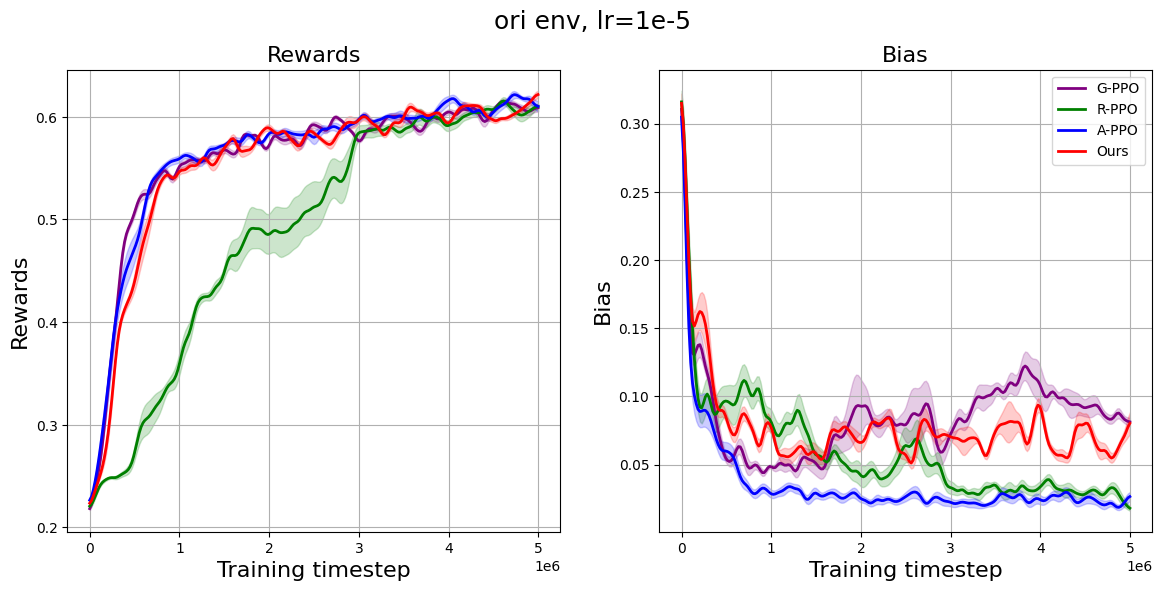

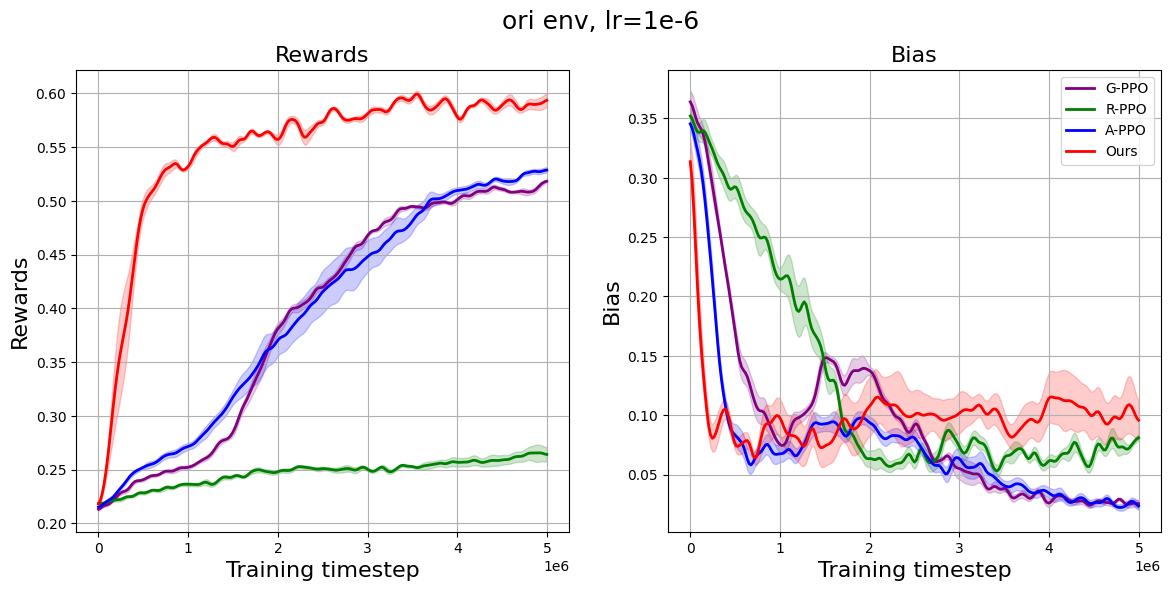

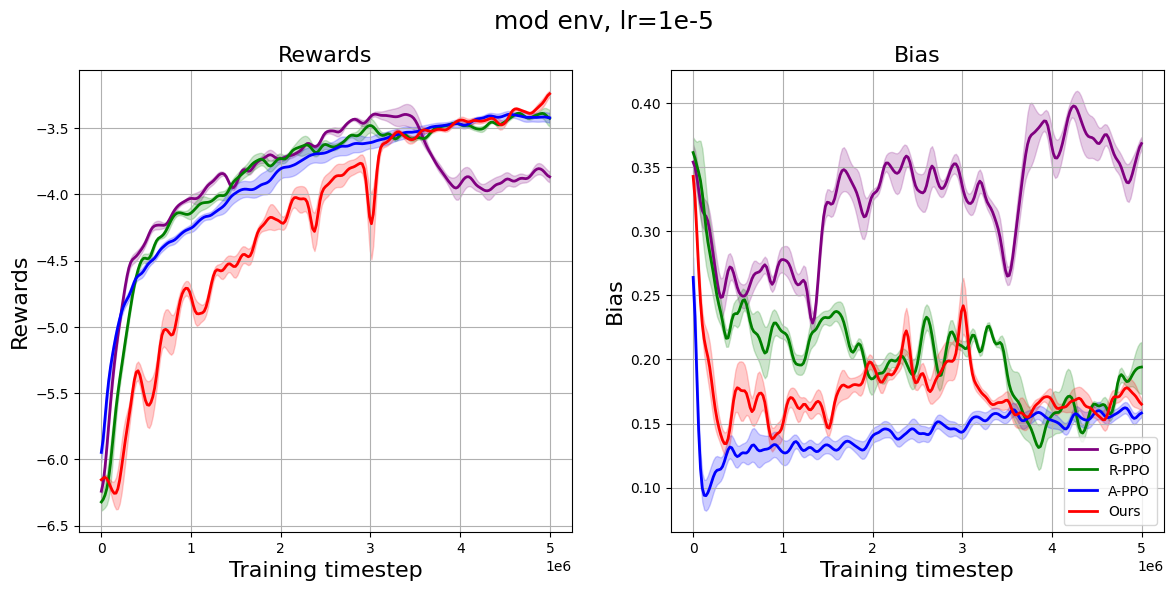

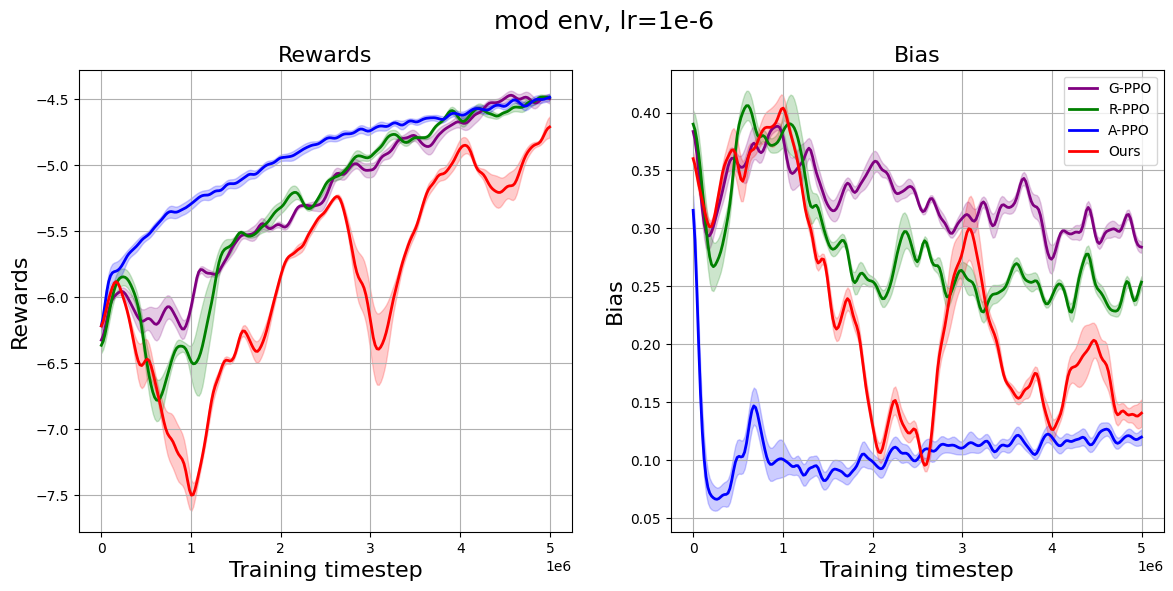

In [32]:
exp_ori_dict = {
    "G-PPO":("experiments/original/GPPO/", 2),
    "R-PPO":("experiments/original/RPPO/", 3),
    "A-PPO":("experiments/original/APPO/", 3),
    "Ours":("experiments/original/ours/Smooth_3.0/b_10.0", 2)
}

exp_ori_6_dict = {
    "G-PPO":("experiments/original/GPPO/_lr1e-6", 2),
    "R-PPO":("experiments/original/RPPO/_lr1e-6", 2),
    "A-PPO":("experiments/original/APPO/_lr1e-6", 3),
    "Ours":("experiments/original/ours/Smooth_10.0/b_20.0", 2)
}

exp_mod_dict = {
    "G-PPO":("experiments/Chenghao_env_05_14/GPPO/", 2),
    "R-PPO":("experiments/Chenghao_env_05_14/RPPO/", 2),
    "A-PPO":("experiments/Chenghao_env_05_14/APPO/", 4),
    "Ours":("experiments/Chenghao_env_05_14/ours/Smooth_30.0/b_4000.0_lr1e-5", 2)
}

exp_mod_6_dict = {
    "G-PPO":("experiments/Chenghao_env_05_14/GPPO/_lr1e-6", 2),
    "R-PPO":("experiments/Chenghao_env_05_14/RPPO/_lr1e-6", 2),
    "A-PPO":("experiments/Chenghao_env_05_14/APPO/_lr1e-6", 4),
    "Ours":("experiments/Chenghao_env_05_14/ours/Smooth_20.0/b_2000.0_lr1e-6", 2)
}

model_color_dict = {
    "G-PPO":"purple",
    "R-PPO":"green",
    "A-PPO":"blue",
    "Ours":"red"
}

load_and_plot(exp_ori_dict, model_color_dict, "ori env, lr=1e-5", "fig_lending")
load_and_plot(exp_ori_6_dict, model_color_dict, "ori env, lr=1e-6", "fig_lending")
load_and_plot(exp_mod_dict, model_color_dict, "mod env, lr=1e-5", "fig_lending")
load_and_plot(exp_mod_6_dict, model_color_dict, "mod env, lr=1e-6", "fig_lending")